<a href="https://colab.research.google.com/github/Abdoul1996/Alzheimer_Classification/blob/main/Russ_alzheimer_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import torch
from sklearn.metrics import confusion_matrix, classification_report
from pathlib import Path
import os
import numpy as np
from numpy import expand_dims
import cv2
import nibabel as nib
import matplotlib.pyplot as plt
import glob
import pandas as pd
from pathlib import Path
from google.colab import drive
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from skimage.color import gray2rgb
from sklearn.utils import shuffle
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')

# Data Loading


In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 13.1 MB/s eta 0:00:00


In [ ]:
import pydicom

In [ ]:
!apt-get update -y && apt-get install -y fuse lsb-release; \
    curl -L -O https://github.com/GoogleCloudPlatform/gcsfuse/releases/download/v0.41.12/gcsfuse_0.41.12_amd64.deb; \
    dpkg --install gcsfuse_0.41.12_amd64.deb; \
    apt-get update; \
    apt-get clean;

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,192 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,532 kB]
Get:13 http://security.ubuntu.com/ubuntu

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
project_id = 'sfsu-378805'
bucket_name = 'csc-509-image-files'
!gcloud config set project {project_id}

Are you sure you wish to set property [core/project] to sfsu-378805?

Do you want to continue (Y/n)?  y

Updated property [core/project].


In [ ]:
!gsutil ls

You are attempting to access protected data with no configured
credentials. Please visit https://cloud.google.com/console#/project
and sign up for an account, and then run the "gcloud auth login"
command to configure gsutil to use these credentials.


In [ ]:
!mkdir images

In [ ]:
!gcsfuse --implicit-dirs csc-509-image-files images

2024/12/07 18:49:47.200433 Start gcsfuse/0.41.12 (Go version go1.18.4) for app "" using mount point: /content/images
2024/12/07 18:49:47.227102 Opening GCS connection...
2024/12/07 18:49:48.540291 Mounting file system "csc-509-image-files"...
2024/12/07 18:49:48.541123 File system has been successfully mounted.


In [ ]:
!ls images/

Archive				Module0_UPENNGBM  Module1_BraTS.tar.bz2  Module2_ADNI_New
Module0_DataCuration		Module1_ADNI	  Module1_PET
Module0_MRI_PET_Classification	Module1_BraTS	  Module2_ADNI


In [ ]:
DATA_PATH = Path('/content/images/Module2_ADNI/')

In [ ]:
os.listdir(Path(DATA_PATH, 'CSVS',))

['ADNI_AMYPet_withClinicalData_01122023.csv',
 'ADNI_AmyPET_MiddleSlices_ClinicalData.csv',
 'ADNI_ClinicalData.csv',
 'ADNI_FDGPET_FILEPATH_TO_DICOM_FOLDER_ClinicalData.csv',
 'ADNI_MissingClinicalData.csv',
 'ADNI_PET_MiddleSlices_ClinicalData.csv']

In [ ]:
data_df = pd.read_csv(Path(DATA_PATH,'CSVS/ADNI_AMYPet_withClinicalData_01122023.csv'))
data_df = data_df[data_df['SLICE_NUM'] == 48].reset_index(drop = True)
print(len(data_df))
data_df.head()

445


,Unnamed: 0,FILEPATH_MIDDLE_SLICES,SLICE_NUM,AMYPET_TYPE,Subject,Image Data ID,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,0,images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...,48,"AV45_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_...",002_S_4447,I285198,EMCI,F,68,23,PET,"AV45 Coreg, Avg, Std Img and Vox Siz, Uniform ...",Processed,2/13/2012,DCM,9/16/2021
1,1,images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...,48,"AV45_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_...",002_S_4447,I285200,EMCI,F,68,23,PET,AV45 Co-registered Dynamic,Processed,2/13/2012,DCM,9/16/2021
2,2,images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...,48,"AV45_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_...",002_S_4447,I285197,EMCI,F,68,23,PET,"AV45 Coreg, Avg, Standardized Image and Voxel ...",Processed,2/13/2012,DCM,9/16/2021
3,3,images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...,48,"AV45_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_...",002_S_4447,I285199,EMCI,F,68,23,PET,"AV45 Co-registered, Averaged",Processed,2/13/2012,DCM,9/16/2021
4,4,images/Module2_ADNI/PET_1/003_S_4288/AV45_Core...,48,"AV45_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_...",003_S_4288,I272168,CN,F,73,23,PET,"AV45 Coreg, Avg, Standardized Image and Voxel ...",Processed,12/06/2011,DCM,9/16/2021


In [ ]:
data_df['FOLDERPATH_MIDDLE_SLICES'] = data_df['FILEPATH_MIDDLE_SLICES'].str.rsplit('/', n = 1).str[0]
data_df['Group'].unique()

array(['EMCI', 'CN', 'AD', 'LMCI', 'SMC', 'MCI'], dtype=object)

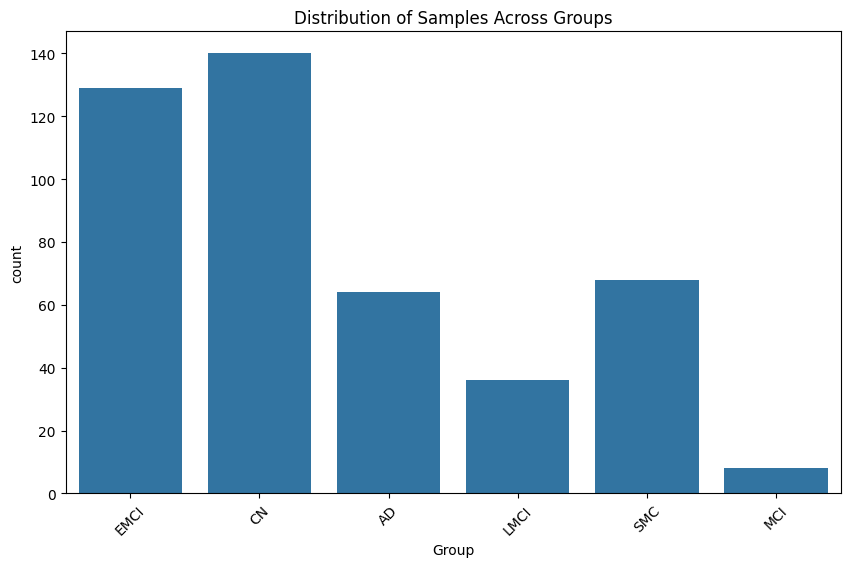

In [ ]:
# Bar plot of group distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=data_df, x='Group')
plt.title('Distribution of Samples Across Groups')
plt.xticks(rotation=45)
plt.show()

In [ ]:
data_df = data_df[['Image Data ID', 'FILEPATH_MIDDLE_SLICES', 'FOLDERPATH_MIDDLE_SLICES', 'Group' ]]
data_df_filt = data_df[data_df['Group'].isin(['AD', 'EMCI','CN'])].reset_index(drop = True)
print("Number of patient ids:", len(data_df_filt))

Number of patient ids: 333


In [ ]:
data_df_filt[['Image Data ID', 'Group']].groupby(by = 'Group').count()

,Image Data ID
Group,
AD,64
CN,140
EMCI,129


In [ ]:
# Split into training, validation set and test set
ids = data_df_filt['Image Data ID'].unique()

# Here we have selected the size of test set as 15 %
train_ids, test_ids = train_test_split(ids,test_size=0.15)

# Create validation ids by further splitting the train ids, we again use 15 % as size of validation set. Validation set is also referred to as tuning set.
train_ids, val_ids = train_test_split(train_ids,test_size=0.15)


In [ ]:
# Let's check the number of patients ids in train, validation and test set
print(f'There are {len(train_ids)} patient ids in training set')
print(f'There are {len(val_ids)} patient ids in validation set')
print(f'There are {len(test_ids)} patient ids in test set')

There are 240 patient ids in training set
There are 43 patient ids in validation set
There are 50 patient ids in test set


In [ ]:
# Let's check the number of CN and AD patients in the splits. We want our splits to be balanced.
data_df_filt['Split'] = np.where(data_df_filt['Image Data ID'].isin(train_ids), 'Train', '')
data_df_filt['Split'] = np.where(data_df_filt['Image Data ID'].isin(val_ids), 'Validation', data_df_filt['Split'])
data_df_filt['Split'] = np.where(data_df_filt['Image Data ID'].isin(test_ids), 'Test', data_df_filt['Split'])

data_df_filt[['Image Data ID', 'Group', 'Split']].groupby(by = ['Split', 'Group']).count()

Image Data ID
Split      Group               
Test       AD                10
           CN                18
           EMCI              22
Train      AD                48
           CN               101
           EMCI              91
Validation AD                 6
           CN                21
           EMCI              16

In [ ]:
# Let's create a function to normalize the image between 0 and 1 and change label to 0 and 1
def normalize(image, label, percentile = 0.001,
              eps = 0.0000001):


    img_array = np.ndarray.flatten(image)
    min_img, max_img = np.quantile(img_array, percentile), np.quantile(img_array, 1-percentile)
    img_normalized = ((image-min_img)/(max_img-min_img+eps)*255).astype(np.uint8)
    input_image = torch.tensor(img_normalized, dtype=torch.float32)/255

    if label == 'CN':
      input_label = 0
    elif label == 'EMCI':
      input_label = 1
    elif label == 'AD':
        input_label = 2
    else:
        raise ValueError(f"Unexpected label: {label}")


    return input_image, input_label

In [ ]:
# Let's create a function read dicoms and sort by slice number

def read_all_dicom_slices(dicom_directory):
    """
    Will read in the images from a single dicom folder and return a dictionary of
    those images with the key as the presumed slice number, and the value being the pixel array.

    dicom_directory: Path or string that leads to the folder containing the slices

    """
    dicom_image_dict = {}
    for image in glob.glob(str(Path(dicom_directory, '*'))):
      key = image.split('/')[-1].split('_')[-3]
      dicom_image_dict[key]= pydicom.dcmread(image)
    return dicom_image_dict

In [ ]:
# Let's create a function to create numpy arrays using the above 2 functions

def create_numpy_array(df):
  X = []
  Y = []
  for i in range(len(df)):
    print("i:"+ str(i))
    dicom_volume = read_all_dicom_slices(df['FOLDERPATH_MIDDLE_SLICES'][i])
    print(dicom_volume)
    keys_sorted = [str(x) for x in sorted([int(x) for x in list(dicom_volume.keys())])]
    print(keys_sorted)
    keys_filt = [46, 47, 48, 49, 50] # picks up 5 slices per image
    for key in keys_filt: # iterates through the dictionary, while the enumerate function keeps track of the index with j
        value = dicom_volume[str(key)]
        image = value.pixel_array
        label = df['Group'][i]
        new_image, new_label = normalize(image, label)
        X.append(new_image)
        Y.append(new_label)
  return np.asarray(X), np.asarray(Y)

In [ ]:
#Let's create numpy arrays for training, validation and test sets using the above 3 functions
X_train, Y_train = create_numpy_array(data_df_filt[data_df_filt['Split'] == 'Train'].reset_index(drop = True))
X_val, Y_val = create_numpy_array(data_df_filt[data_df_filt['Split'] == 'Validation'].reset_index(drop = True))
X_test, Y_test = create_numpy_array(data_df_filt[data_df_filt['Split'] == 'Test'].reset_index(drop = True))

Streaming output truncated to the last 5000 lines.
   ---------
(0054,0016)  Radiopharmaceutical Information Sequence  1 item(s) ---- 
   (0018,0031) Radiopharmaceutical                 LO: 'AV45'
   ---------
(0054,0081) Number of Slices                    US: 96
(0054,0101) Number of Time Slices               US: 1
(0054,1000) Series Type                         CS: ['STATIC', 'IMAGE']
(0054,1001) Units                               CS: 'NONE'
(0054,1002) Counts Source                       CS: 'EMISSION'
(0054,1100) Randoms Correction Method           CS: 'SING'
(0054,1101) Attenuation Correction Method       LO: 'measured,, 0.096000 cm-1,'
(0054,1103) Reconstruction Method               LO: '3D IR'
(0054,1105) Scatter Correction Method           LO: 'Model Based'
(0054,1200) Axial Acceptance                    DS: ''
(0054,1201) Axial Mash                          IS: [1, 2]
(0054,1202) Transverse Mash                     IS: '2'
(0054,1300) Frame Reference Time                DS: 

In [ ]:
# Let's save the train, validation and test arrays to a path in your drive
np.save('/content/drive/MyDrive/Numpy_ADNI/AmyPET_train_images.npy', X_train) # Enter the path where you will save the file
np.save('/content/drive/MyDrive/Numpy_ADNI/AmyPET_val_images.npy', X_val)
np.save('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_images.npy', X_test)
np.save('/content/drive/MyDrive/Numpy_ADNI/AmyPET_train_label.npy', Y_train)
np.save('/content/drive/MyDrive/Numpy_ADNI/AmyPET_val_label.npy', Y_val)
np.save('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_label.npy', Y_test)

# Model Training

In [ ]:
# Let's load the train, validation and test arrays
X_train = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_train_images.npy', allow_pickle=True)
X_val = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_val_images.npy', allow_pickle=True)
X_test = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_images.npy', allow_pickle=True)
Y_train = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_train_label.npy', allow_pickle=True)
Y_val = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_val_label.npy', allow_pickle=True)
Y_test = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_label.npy', allow_pickle=True)

In [ ]:
# Converting grayscale images to RGB
X_train = np.array([gray2rgb(X_train[i]) for i in range(len(X_train))])
X_val = np.array([gray2rgb(X_val[i]) for i in range(len(X_val))])
X_test = np.array([gray2rgb(X_test[i]) for i in range(len(X_test))])

In [ ]:
X_train, Y_train = shuffle(X_train, Y_train, random_state = 0)
X_val, Y_val = shuffle(X_val, Y_val, random_state = 0)
X_test, Y_test = shuffle(X_test, Y_test, random_state = 0)

In [ ]:
# Let's confirm the size of the training and validation arrays
print(f'There are {len(X_train)} images in training set')
print(f'There are {len(X_val)} images in validation set')
print(f'There are {len(X_test)} images in test set')

There are 1200 images in training set
There are 215 images in validation set
There are 250 images in test set


In [ ]:
# Let's create the train, validation and test tensor datasets
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
dataset_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = dataset_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = dataset_val.batch(BATCH_SIZE)
test_dataset = dataset_test.batch(BATCH_SIZE)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 7
Number of test batches: 8


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TF
import random

In [ ]:
class PETClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(PETClassifier, self).__init__()
        self.base_model = models.inception_v3(pretrained=True)

        # Unfreeze the last 2 inception blocks
        for name, param in self.base_model.named_parameters():
            if "Mixed_7" in name or "Mixed_6" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        # Modify the final classifier with batch normalization
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.BatchNorm1d(num_features),
            nn.Dropout(0.4),  # Increased dropout
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        if self.training:
            output, aux_output = self.base_model(x)
            return output, aux_output
        return self.base_model(x)

In [ ]:
class AmyloidPETDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Normalize the image to [0, 1] range
        image = (image - image.min()) / (image.max() - image.min())

        # Convert to PIL Image
        image = Image.fromarray((image * 255).astype(np.uint8))
        image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Modified transforms with custom normalization
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Add small translations
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485],
                        std=[0.229, 0.229, 0.229])
])

val_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485],
                        std=[0.229, 0.229, 0.229])
])

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, device='cuda'):
    model = model.to(device)
    best_val_acc = 0.0
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs, aux_outputs = model(inputs)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2

            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100. * correct / total
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        # Learning rate scheduling
        scheduler.step(epoch_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), 'best_model.pth')

    return history

def main():
    # Load and preprocess data
    X_train = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_train_images.npy', allow_pickle=True)
    X_val = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_val_images.npy', allow_pickle=True)
    X_test = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_images.npy', allow_pickle=True)
    Y_train = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_train_label.npy', allow_pickle=True)
    Y_val = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_val_label.npy', allow_pickle=True)
    Y_test = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_label.npy', allow_pickle=True)

    # Create datasets
    train_dataset = AmyloidPETDataset(X_train, Y_train, transform=train_transform)
    val_dataset = AmyloidPETDataset(X_val, Y_val, transform=val_transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Reduced batch size
    val_loader = DataLoader(val_dataset, batch_size=16)

    # Initialize model and training components
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = PETClassifier(num_classes=3)

    # Higher initial learning rate
    optimizer = optim.Adam([
        {'params': model.base_model.fc.parameters(), 'lr': 1e-3},
        {'params': (p for n, p in model.base_model.named_parameters() if 'fc' not in n and p.requires_grad), 'lr': 1e-4}
    ])

    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    # Train for more epochs
    history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                         num_epochs=10, device=device)

if __name__ == '__main__':
    main()

Epoch 1/10:
Train Loss: 3.5919, Train Acc: 61.83%
Val Loss: 0.5703, Val Acc: 75.35%
Learning Rate: 0.001000
Epoch 2/10:
Train Loss: 1.5754, Train Acc: 87.08%
Val Loss: 0.0156, Val Acc: 100.00%
Learning Rate: 0.001000
Epoch 3/10:
Train Loss: 0.6269, Train Acc: 94.67%
Val Loss: 0.1393, Val Acc: 93.95%
Learning Rate: 0.001000
Epoch 4/10:
Train Loss: 0.4036, Train Acc: 94.67%
Val Loss: 0.0019, Val Acc: 100.00%
Learning Rate: 0.001000
Epoch 5/10:
Train Loss: 0.3338, Train Acc: 96.17%
Val Loss: 0.0183, Val Acc: 99.53%
Learning Rate: 0.001000
Epoch 6/10:
Train Loss: 0.3076, Train Acc: 95.67%
Val Loss: 0.0425, Val Acc: 98.14%
Learning Rate: 0.001000
Epoch 7/10:
Train Loss: 0.1757, Train Acc: 97.75%
Val Loss: 0.0048, Val Acc: 100.00%
Learning Rate: 0.000500
Epoch 8/10:
Train Loss: 0.1218, Train Acc: 98.42%
Val Loss: 0.0003, Val Acc: 100.00%
Learning Rate: 0.000500
Epoch 9/10:
Train Loss: 0.0958, Train Acc: 98.75%
Val Loss: 0.0009, Val Acc: 100.00%
Learning Rate: 0.000500
Epoch 10/10:
Train Loss

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load the existing best model
model = PETClassifier(num_classes=3)
model.load_state_dict(torch.load('best_model.pth'))

# Save it to Google Drive
save_path = '/content/drive/MyDrive/Numpy_ADNI/best_model.pth'
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/MyDrive/Numpy_ADNI/best_model.pth


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Test Set Evaluation Results:
Average Loss: 0.1368
Accuracy: 95.60%

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        90
           1       1.00      0.90      0.95       110
           2       1.00      1.00      1.00        50

    accuracy                           0.96       250
   macro avg       0.96      0.97      0.96       250
weighted avg       0.96      0.96      0.96       250


Confusion Matrix:


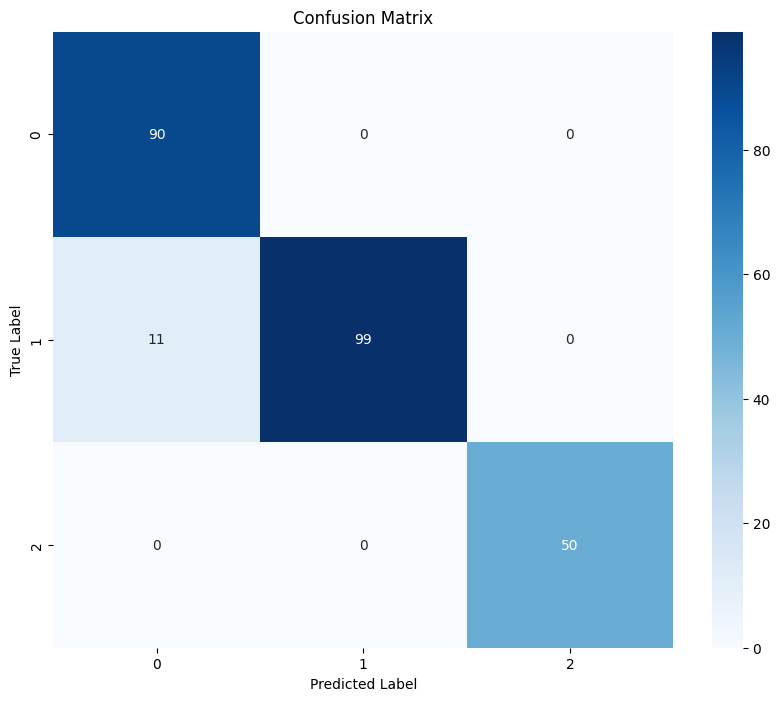

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    # Lists to store predictions and true labels
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Store predictions and labels
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy
    avg_loss = test_loss / len(test_loader)
    accuracy = 100. * correct / total

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions)

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report,
        'predictions': all_predictions,
        'true_labels': all_labels
    }

def plot_confusion_matrix(cm):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def main_evaluation():
    X_test = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_images.npy', allow_pickle=True)
    Y_test = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_label.npy', allow_pickle=True)

    # Create test dataset and loader
    test_dataset = AmyloidPETDataset(X_test, Y_test, transform=val_transform)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # Initialize model and load trained weights
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = PETClassifier(num_classes=3)
    model.load_state_dict(torch.load('/content/drive/MyDrive/Numpy_ADNI/best_model.pth'))
    model = model.to(device)

    # Set up criterion
    criterion = nn.CrossEntropyLoss()

    # Evaluate model
    results = evaluate_model(model, test_loader, criterion, device)

    # Print results
    print("\nTest Set Evaluation Results:")
    print(f"Average Loss: {results['loss']:.4f}")
    print(f"Accuracy: {results['accuracy']:.2f}%")
    print("\nClassification Report:")
    print(results['classification_report'])

    # Plot confusion matrix
    print("\nConfusion Matrix:")
    plot_confusion_matrix(results['confusion_matrix'])

    return results

if __name__ == '__main__':
    results = main_evaluation()

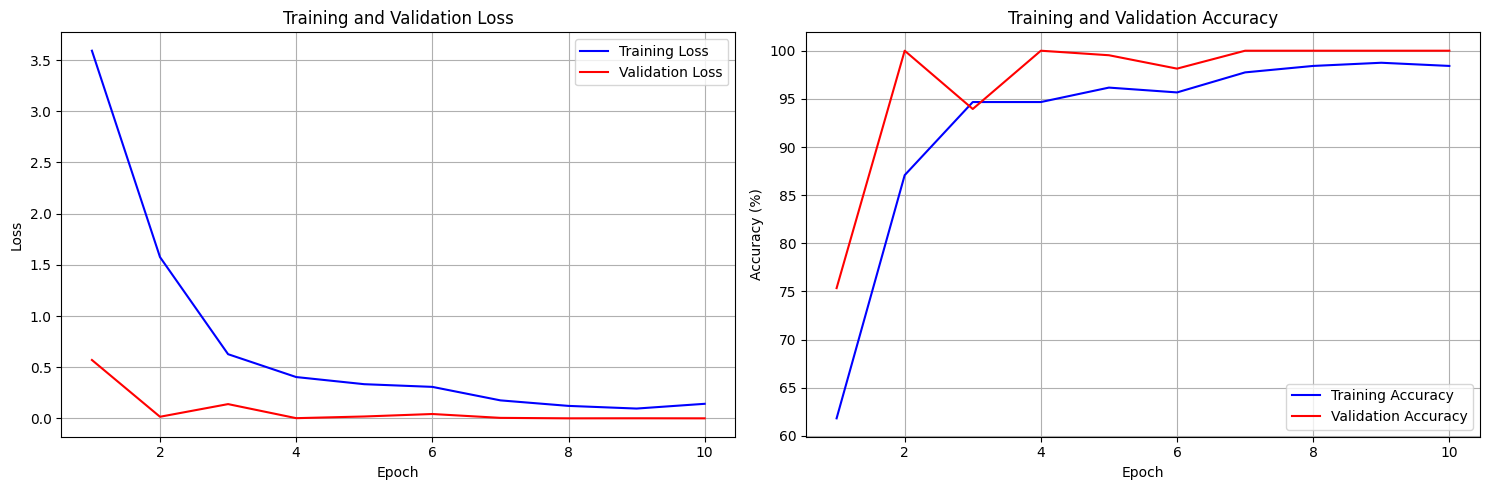


Training Analysis:
Initial training loss: 3.5919
Final training loss: 0.1422
Best training accuracy: 98.75%
Final training accuracy: 98.42%

Validation Analysis:
Initial validation loss: 0.5703
Final validation loss: 0.0002
Best validation accuracy: 100.00%
Final validation accuracy: 100.00%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract values from the training output
train_loss = [3.5919, 1.5754, 0.6269, 0.4036, 0.3338, 0.3076, 0.1757, 0.1218, 0.0958, 0.1422]
val_loss = [0.5703, 0.0156, 0.1393, 0.0019, 0.0183, 0.0425, 0.0048, 0.0003, 0.0009, 0.0002]
train_acc = [61.83, 87.08, 94.67, 94.67, 96.17, 95.67, 97.75, 98.42, 98.75, 98.42]
val_acc = [75.35, 100.00, 93.95, 100.00, 99.53, 98.14, 100.00, 100.00, 100.00, 100.00]

epochs = range(1, 11)

plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print some analysis
print("\nTraining Analysis:")
print(f"Initial training loss: {train_loss[0]:.4f}")
print(f"Final training loss: {train_loss[-1]:.4f}")
print(f"Best training accuracy: {max(train_acc):.2f}%")
print(f"Final training accuracy: {train_acc[-1]:.2f}%")
print("\nValidation Analysis:")
print(f"Initial validation loss: {val_loss[0]:.4f}")
print(f"Final validation loss: {val_loss[-1]:.4f}")
print(f"Best validation accuracy: {max(val_acc):.2f}%")
print(f"Final validation accuracy: {val_acc[-1]:.2f}%")

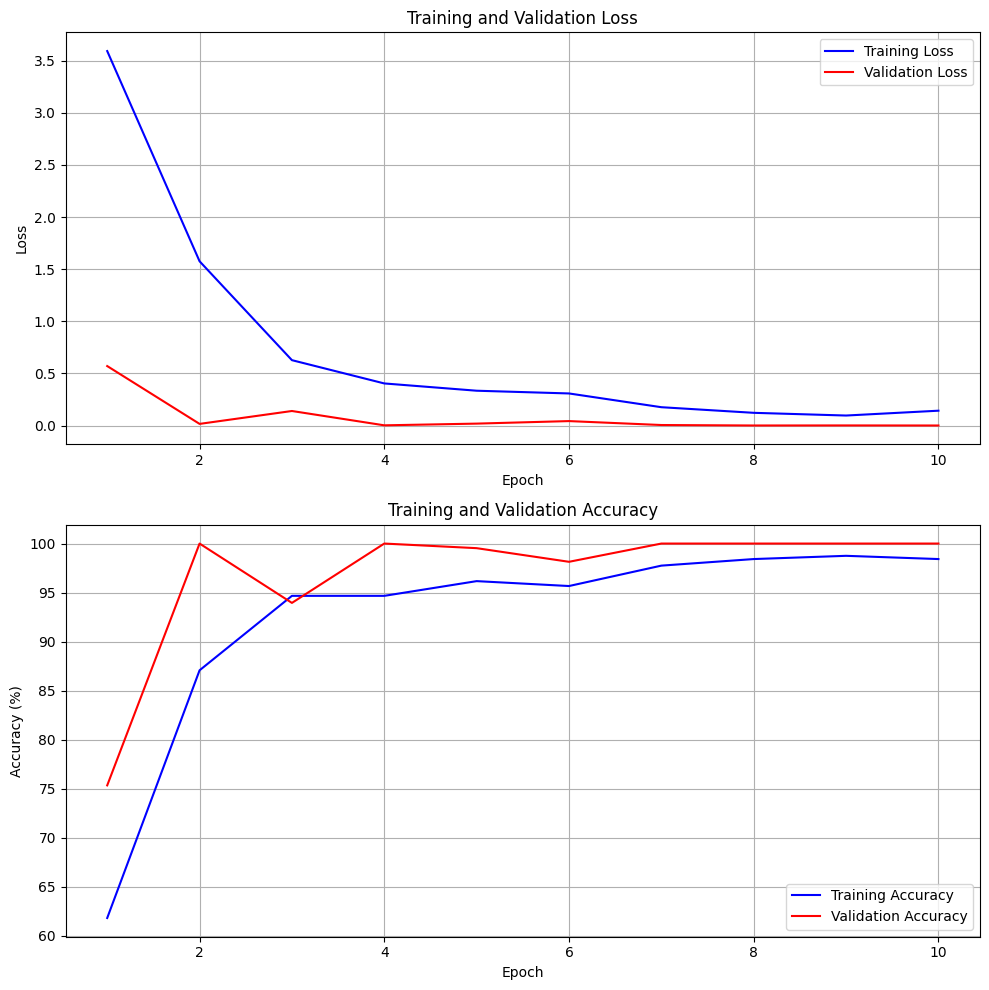


Training Analysis:
Initial training loss: 3.5919
Final training loss: 0.1422
Best training accuracy: 98.75%
Final training accuracy: 98.42%

Validation Analysis:
Initial validation loss: 0.5703
Final validation loss: 0.0002
Best validation accuracy: 100.00%
Final validation accuracy: 100.00%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract values from the training output
train_loss = [3.5919, 1.5754, 0.6269, 0.4036, 0.3338, 0.3076, 0.1757, 0.1218, 0.0958, 0.1422]
val_loss = [0.5703, 0.0156, 0.1393, 0.0019, 0.0183, 0.0425, 0.0048, 0.0003, 0.0009, 0.0002]
train_acc = [61.83, 87.08, 94.67, 94.67, 96.17, 95.67, 97.75, 98.42, 98.75, 98.42]
val_acc = [75.35, 100.00, 93.95, 100.00, 99.53, 98.14, 100.00, 100.00, 100.00, 100.00]

epochs = range(1, 11)

# Create figure with 2 rows and 1 column
plt.figure(figsize=(10, 10))

# Plot Loss
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print some analysis
print("\nTraining Analysis:")
print(f"Initial training loss: {train_loss[0]:.4f}")
print(f"Final training loss: {train_loss[-1]:.4f}")
print(f"Best training accuracy: {max(train_acc):.2f}%")
print(f"Final training accuracy: {train_acc[-1]:.2f}%")
print("\nValidation Analysis:")
print(f"Initial validation loss: {val_loss[0]:.4f}")
print(f"Final validation loss: {val_loss[-1]:.4f}")
print(f"Best validation accuracy: {max(val_acc):.2f}%")
print(f"Final validation accuracy: {val_acc[-1]:.2f}%")


Train Set Results:
Accuracy: 99.08%


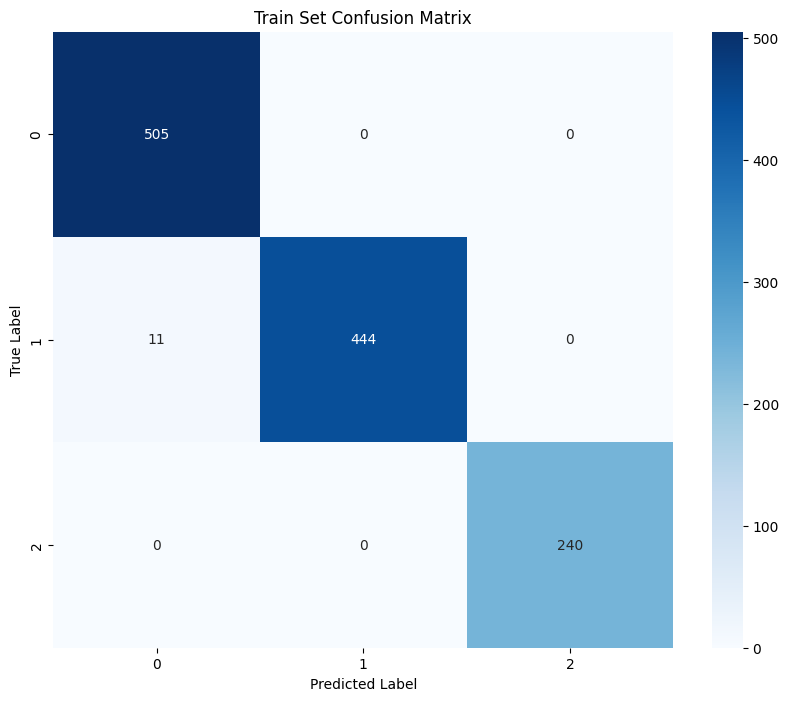


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       505
           1       1.00      0.98      0.99       455
           2       1.00      1.00      1.00       240

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200


Train Set Prediction Distribution:
Class 0: 516 predictions (43.00%)
Class 1: 444 predictions (37.00%)
Class 2: 240 predictions (20.00%)

Validation Set Results:
Accuracy: 100.00%


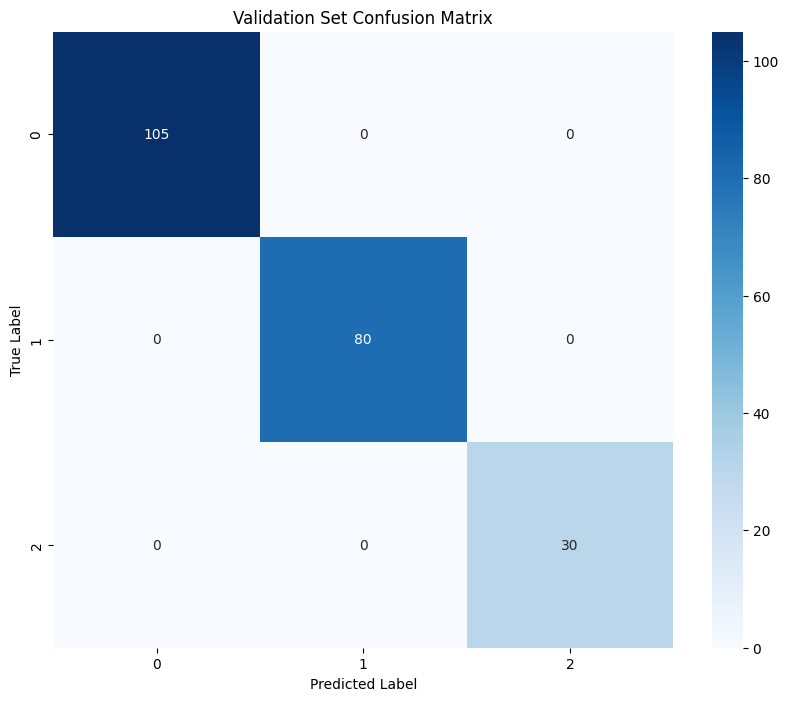


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       1.00      1.00      1.00        80
           2       1.00      1.00      1.00        30

    accuracy                           1.00       215
   macro avg       1.00      1.00      1.00       215
weighted avg       1.00      1.00      1.00       215


Validation Set Prediction Distribution:
Class 0: 105 predictions (48.84%)
Class 1: 80 predictions (37.21%)
Class 2: 30 predictions (13.95%)

Test Set Results:
Accuracy: 95.60%


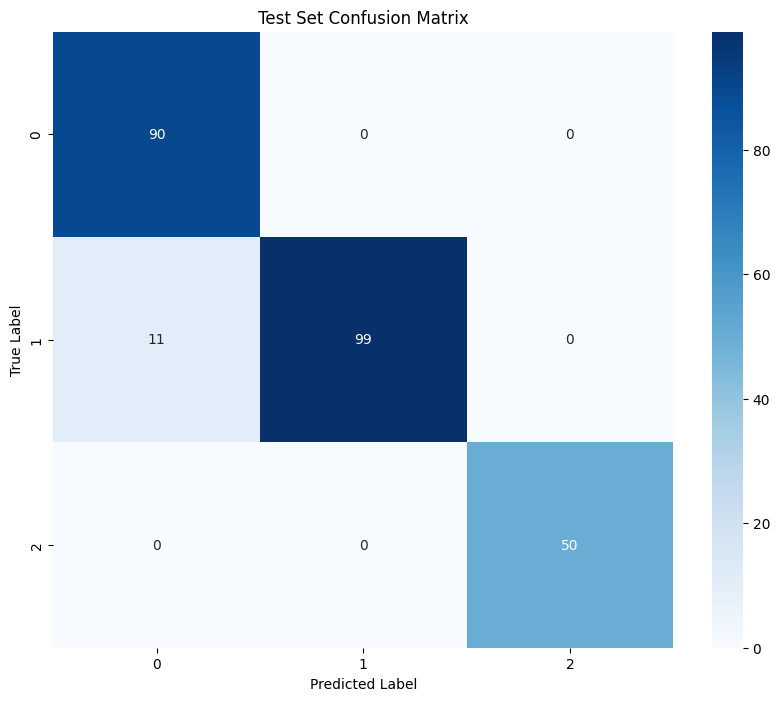


Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        90
           1       1.00      0.90      0.95       110
           2       1.00      1.00      1.00        50

    accuracy                           0.96       250
   macro avg       0.96      0.97      0.96       250
weighted avg       0.96      0.96      0.96       250


Test Set Prediction Distribution:
Class 0: 101 predictions (40.40%)
Class 1: 99 predictions (39.60%)
Class 2: 50 predictions (20.00%)

Performance Gap Analysis:
Train-Test Gap: 3.48%
Train-Val Gap: -0.92%


In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_predictions(true_labels, predictions, title="Confusion Matrix"):
    # Create and plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions))

def check_overfitting(model, train_loader, val_loader, test_loader, device):
    model.eval()
    datasets = {'Train': train_loader, 'Validation': val_loader, 'Test': test_loader}
    results = {}

    with torch.no_grad():
        for name, loader in datasets.items():
            correct = 0
            total = 0
            all_preds = []
            all_labels = []

            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)

                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            accuracy = 100. * correct / total
            results[name] = {
                'accuracy': accuracy,
                'predictions': all_preds,
                'true_labels': all_labels
            }

            print(f"\n{name} Set Results:")
            print(f"Accuracy: {accuracy:.2f}%")
            evaluate_predictions(all_labels, all_preds, f"{name} Set Confusion Matrix")

            # Check prediction distribution
            print(f"\n{name} Set Prediction Distribution:")
            unique, counts = np.unique(all_preds, return_counts=True)
            for label, count in zip(unique, counts):
                print(f"Class {label}: {count} predictions ({count/len(all_preds)*100:.2f}%)")

    return results

def main():
    # Load the saved model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = PETClassifier(num_classes=3)
    model.load_state_dict(torch.load('best_model.pth'))
    model = model.to(device)

    # Load all datasets
    X_train = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_train_images.npy', allow_pickle=True)
    X_val = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_val_images.npy', allow_pickle=True)
    X_test = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_images.npy', allow_pickle=True)
    Y_train = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_train_label.npy', allow_pickle=True)
    Y_val = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_val_label.npy', allow_pickle=True)
    Y_test = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_label.npy', allow_pickle=True)

    # Create all datasets
    train_dataset = AmyloidPETDataset(X_train, Y_train, transform=val_transform)  # Use val_transform to avoid augmentation
    val_dataset = AmyloidPETDataset(X_val, Y_val, transform=val_transform)
    test_dataset = AmyloidPETDataset(X_test, Y_test, transform=val_transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)  # No shuffle for evaluation
    val_loader = DataLoader(val_dataset, batch_size=16)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # Perform comprehensive evaluation
    results = check_overfitting(model, train_loader, val_loader, test_loader, device)

    # Additional analysis
    print("\nPerformance Gap Analysis:")
    print(f"Train-Test Gap: {results['Train']['accuracy'] - results['Test']['accuracy']:.2f}%")
    print(f"Train-Val Gap: {results['Train']['accuracy'] - results['Validation']['accuracy']:.2f}%")

if __name__ == '__main__':
    main()

In [ ]:
def print_model_summary(model):
    """
    Print a detailed summary of the PET Classifier model architecture
    """
    print("=" * 50)
    print("PET CLASSIFIER MODEL SUMMARY")
    print("=" * 50)

    # Base Model Information
    print("\n1. Base Model:")
    print("-" * 20)
    print("Architecture: Inception V3")

    # Layer Freeze Status
    print("\n2. Layer Freeze Status:")
    print("-" * 20)
    frozen_count = 0
    trainable_count = 0

    print("\nFrozen Layers:")
    for name, param in model.base_model.named_parameters():
        if not param.requires_grad:
            print(f"  - {name}")
            frozen_count += 1

    print("\nTrainable Layers:")
    for name, param in model.base_model.named_parameters():
        if param.requires_grad:
            print(f"  - {name}")
            trainable_count += 1

    print(f"\nTotal frozen layers: {frozen_count}")
    print(f"Total trainable layers: {trainable_count}")

    # Custom Classifier Information
    print("\n3. Custom Classifier Architecture:")
    print("-" * 20)
    print("Layer Structure:")
    for idx, layer in enumerate(model.base_model.fc):
        print(f"  {idx+1}. {layer.__class__.__name__}")
        if isinstance(layer, nn.Linear):
            print(f"     Input features: {layer.in_features}")
            print(f"     Output features: {layer.out_features}")
        elif isinstance(layer, nn.Dropout):
            print(f"     Dropout rate: {layer.p}")

    # Parameter Summary
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print("\n4. Parameter Summary:")
    print("-" * 20)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {total_params - trainable_params:,}")
    print("\n" + "=" * 50)

# Create and summarize model
model = PETClassifier(num_classes=3)
print_model_summary(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


PET CLASSIFIER MODEL SUMMARY

1. Base Model:
--------------------
Architecture: Inception V3

2. Layer Freeze Status:
--------------------

Frozen Layers:
  - Conv2d_1a_3x3.conv.weight
  - Conv2d_1a_3x3.bn.weight
  - Conv2d_1a_3x3.bn.bias
  - Conv2d_2a_3x3.conv.weight
  - Conv2d_2a_3x3.bn.weight
  - Conv2d_2a_3x3.bn.bias
  - Conv2d_2b_3x3.conv.weight
  - Conv2d_2b_3x3.bn.weight
  - Conv2d_2b_3x3.bn.bias
  - Conv2d_3b_1x1.conv.weight
  - Conv2d_3b_1x1.bn.weight
  - Conv2d_3b_1x1.bn.bias
  - Conv2d_4a_3x3.conv.weight
  - Conv2d_4a_3x3.bn.weight
  - Conv2d_4a_3x3.bn.bias
  - Mixed_5b.branch1x1.conv.weight
  - Mixed_5b.branch1x1.bn.weight
  - Mixed_5b.branch1x1.bn.bias
  - Mixed_5b.branch5x5_1.conv.weight
  - Mixed_5b.branch5x5_1.bn.weight
  - Mixed_5b.branch5x5_1.bn.bias
  - Mixed_5b.branch5x5_2.conv.weight
  - Mixed_5b.branch5x5_2.bn.weight
  - Mixed_5b.branch5x5_2.bn.bias
  - Mixed_5b.branch3x3dbl_1.conv.weight
  - Mixed_5b.branch3x3dbl_1.bn.weight
  - Mixed_5b.branch3x3dbl_1.bn.bias
  

In [ ]:
def create_table_border(width=80):
    return "+" + "-" * (width-2) + "+"

def create_table_row(text, width=80):
    return f"| {text:<{width-4}} |"

def create_section_header(text, width=80):
    border = create_table_border(width)
    header = create_table_row(text.upper(), width)
    return f"{border}\n{header}\n{border}"

def print_enhanced_summary(model):
    width = 80

    # Title
    print("\n" + "=" * width)
    print(f"{'PET CLASSIFIER MODEL SUMMARY':^{width}}")
    print("=" * width + "\n")

    # 1. Base Model Section
    print(create_section_header("1. Base Model Architecture", width))
    print(create_table_row("Type: Inception V3 (pretrained)", width))
    print(create_table_row("Input Size: 299 x 299 x 3", width))
    print(create_table_border(width) + "\n")

    # 2. Layer Status Section
    print(create_section_header("2. Layer Freeze Status", width))

    # Count frozen and trainable parameters
    frozen_layers = []
    trainable_layers = []
    for name, param in model.base_model.named_parameters():
        if not param.requires_grad:
            frozen_layers.append(name)
        else:
            trainable_layers.append(name)

    # Print Frozen Layers
    print(create_table_row("FROZEN LAYERS:", width))
    print(create_table_border(width))
    for layer in frozen_layers[:5]:  # Show first 5 layers
        print(create_table_row(f"  • {layer}", width))
    if len(frozen_layers) > 5:
        print(create_table_row(f"  ... and {len(frozen_layers)-5} more layers", width))

    # Print Trainable Layers
    print(create_table_border(width))
    print(create_table_row("TRAINABLE LAYERS:", width))
    print(create_table_border(width))
    for layer in trainable_layers:
        print(create_table_row(f"  • {layer}", width))
    print(create_table_border(width) + "\n")

    # 3. Custom Classifier Section
    print(create_section_header("3. Custom Classifier Architecture", width))

    classifier_layers = [
        ("Batch Normalization", f"Features: {model.base_model.fc[0].num_features}"),
        ("Dropout", f"Rate: 0.4"),
        ("Linear", f"2048 → 512"),
        ("ReLU", "Activation"),
        ("Batch Normalization", f"Features: 512"),
        ("Dropout", f"Rate: 0.4"),
        ("Linear", f"512 → 3")
    ]

    print(create_table_border(width))
    print(f"| {'Layer Type':<30} | {'Specifications':<45} |")
    print(create_table_border(width))

    for layer_type, specs in classifier_layers:
        print(f"| {layer_type:<30} | {specs:<45} |")
    print(create_table_border(width) + "\n")

    # 4. Parameter Summary Section
    print(create_section_header("4. Parameter Summary", width))

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params

    print(create_table_border(width))
    print(f"| {'Parameter Type':<30} | {'Count':<20} | {'Percentage':<23} |")
    print(create_table_border(width))
    print(f"| {'Total Parameters':<30} | {total_params:>20,d} | {100:>22.1f}% |")
    print(f"| {'Trainable Parameters':<30} | {trainable_params:>20,d} | {trainable_params/total_params*100:>22.1f}% |")
    print(f"| {'Frozen Parameters':<30} | {frozen_params:>20,d} | {frozen_params/total_params*100:>22.1f}% |")
    print(create_table_border(width) + "\n")

# Create and summarize model
model = PETClassifier(num_classes=3)
print_enhanced_summary(model)


                          PET CLASSIFIER MODEL SUMMARY                          

+------------------------------------------------------------------------------+
| 1. BASE MODEL ARCHITECTURE                                                   |
+------------------------------------------------------------------------------+
| Type: Inception V3 (pretrained)                                              |
| Input Size: 299 x 299 x 3                                                    |
+------------------------------------------------------------------------------+

+------------------------------------------------------------------------------+
| 2. LAYER FREEZE STATUS                                                       |
+------------------------------------------------------------------------------+
| FROZEN LAYERS:                                                               |
+------------------------------------------------------------------------------+
|   • Conv2d_1a_3x3.conv.

In [ ]:
pip install openpyxl

In [ ]:
import pandas as pd
import openpyxl
from openpyxl.styles import PatternFill, Font, Alignment, Border, Side
from openpyxl.utils import get_column_letter

def export_model_summary_to_excel(model, filename='model_summary.xlsx'):
    """
    Export model summary to a formatted Excel file
    """
    # Create Excel writer
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        # Collect model information
        frozen_layers = []
        trainable_layers = []
        for name, param in model.base_model.named_parameters():
            if not param.requires_grad:
                frozen_layers.append([name, param.shape, param.numel()])
            else:
                trainable_layers.append([name, param.shape, param.numel()])

        # Create DataFrames for each section
        # 1. Base Model Info
        base_info_df = pd.DataFrame([
            ['Model Type', 'Inception V3 (pretrained)'],
            ['Input Size', '299 x 299 x 3'],
            ['Base Model', 'Inception V3']
        ], columns=['Property', 'Value'])

        # 2. Frozen Layers
        frozen_df = pd.DataFrame(frozen_layers,
                               columns=['Layer Name', 'Shape', 'Parameters'])

        # 3. Trainable Layers
        trainable_df = pd.DataFrame(trainable_layers,
                                  columns=['Layer Name', 'Shape', 'Parameters'])

        # 4. Custom Classifier Architecture
        classifier_layers = [
            ['Batch Normalization', f'Features: {model.base_model.fc[0].num_features}'],
            ['Dropout', 'Rate: 0.4'],
            ['Linear', '2048 → 512'],
            ['ReLU', 'Activation'],
            ['Batch Normalization', 'Features: 512'],
            ['Dropout', 'Rate: 0.4'],
            ['Linear', '512 → 3']
        ]
        classifier_df = pd.DataFrame(classifier_layers,
                                   columns=['Layer Type', 'Specifications'])

        # 5. Parameter Summary
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        frozen_params = total_params - trainable_params

        summary_df = pd.DataFrame([
            ['Total Parameters', total_params, '100%'],
            ['Trainable Parameters', trainable_params, f'{trainable_params/total_params*100:.1f}%'],
            ['Frozen Parameters', frozen_params, f'{frozen_params/total_params*100:.1f}%']
        ], columns=['Parameter Type', 'Count', 'Percentage'])

        # Save each DataFrame to different sheets
        dfs = {
            'Base Model Info': base_info_df,
            'Frozen Layers': frozen_df,
            'Trainable Layers': trainable_df,
            'Custom Classifier': classifier_df,
            'Parameter Summary': summary_df
        }

        # Write each DataFrame to Excel with formatting
        for sheet_name, df in dfs.items():
            df.to_excel(writer, sheet_name=sheet_name, index=False)
            worksheet = writer.sheets[sheet_name]

            # Get the dimensions of the DataFrame
            max_row = worksheet.max_row
            max_col = worksheet.max_column

            # Format header
            header_fill = PatternFill(start_color='366092', end_color='366092', fill_type='solid')
            header_font = Font(color='FFFFFF', bold=True)

            # Format cells
            cell_border = Border(
                left=Side(style='thin'),
                right=Side(style='thin'),
                top=Side(style='thin'),
                bottom=Side(style='thin')
            )

            # Apply formatting to header
            for col in range(1, max_col + 1):
                cell = worksheet.cell(1, col)
                cell.fill = header_fill
                cell.font = header_font
                cell.border = cell_border
                cell.alignment = Alignment(horizontal='center', vertical='center')

                # Adjust column width
                worksheet.column_dimensions[get_column_letter(col)].width = 20

            # Apply formatting to data cells
            for row in range(2, max_row + 1):
                for col in range(1, max_col + 1):
                    cell = worksheet.cell(row, col)
                    cell.border = cell_border
                    cell.alignment = Alignment(horizontal='left', vertical='center')

                    # Format numbers in the Parameters column
                    if isinstance(cell.value, (int, float)):
                        cell.number_format = '#,##0'

            # Adjust row height
            for row in range(1, max_row + 1):
                worksheet.row_dimensions[row].height = 20

# Create and export model summary
model = PETClassifier(num_classes=3)
export_model_summary_to_excel(model, 'pet_classifier_summary.xlsx')

print("Model summary has been exported to 'pet_classifier_summary.xlsx'")

Model summary has been exported to 'pet_classifier_summary.xlsx'


In [ ]:
import pandas as pd
import openpyxl
from openpyxl.styles import PatternFill, Font, Alignment, Border, Side
from openpyxl.utils import get_column_letter
from collections import defaultdict

def export_concise_model_summary(model, filename='model_summary.xlsx'):
    """
    Export a concise model summary to a formatted Excel file
    """
    def group_layers(layer_list):
        """Helper function to group layers by their major components"""
        groups = defaultdict(lambda: {'count': 0, 'parameters': 0})
        for name, shape, params in layer_list:
            # Extract the major component name (e.g., 'Mixed_7a' from 'Mixed_7a.branch1x1.conv.weight')
            major_component = name.split('.')[0]
            groups[major_component]['count'] += 1
            groups[major_component]['parameters'] += params
        return groups

    # Collect model information
    frozen_layers = []
    trainable_layers = []
    for name, param in model.base_model.named_parameters():
        if not param.requires_grad:
            frozen_layers.append([name, param.shape, param.numel()])
        else:
            trainable_layers.append([name, param.shape, param.numel()])

    # Group layers
    frozen_groups = group_layers(frozen_layers)
    trainable_groups = group_layers(trainable_layers)

    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        # 1. Base Model Info
        base_info_df = pd.DataFrame([
            ['Model Type', 'Inception V3 (pretrained)'],
            ['Input Size', '299 x 299 x 3'],
            ['Total Layers', len(frozen_layers) + len(trainable_layers)],
            ['Training Strategy', 'Fine-tuning last 2 inception blocks']
        ], columns=['Property', 'Value'])

        # 2. Layer Status Summary
        frozen_summary = []
        for group, stats in frozen_groups.items():
            frozen_summary.append([
                group,
                stats['count'],
                f"{stats['parameters']:,}"
            ])

        trainable_summary = []
        for group, stats in trainable_groups.items():
            trainable_summary.append([
                group,
                stats['count'],
                f"{stats['parameters']:,}"
            ])

        layer_status_df = pd.DataFrame([
            ['FROZEN LAYERS', '', ''],
            *frozen_summary,
            ['', '', ''],
            ['TRAINABLE LAYERS', '', ''],
            *trainable_summary
        ], columns=['Block', 'Layer Count', 'Parameters'])

        # 3. Custom Classifier Architecture
        classifier_df = pd.DataFrame([
            ['Input Layer', '2048 features'],
            ['↓ BatchNorm + Dropout(0.4)', ''],
            ['Hidden Layer', '512 features + ReLU'],
            ['↓ BatchNorm + Dropout(0.4)', ''],
            ['Output Layer', '3 classes (softmax)']
        ], columns=['Layer', 'Specification'])

        # 4. Parameter Summary
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        frozen_params = total_params - trainable_params

        summary_df = pd.DataFrame([
            ['Total Parameters', f"{total_params:,}", '100%'],
            ['Trainable Parameters', f"{trainable_params:,}", f'{trainable_params/total_params*100:.1f}%'],
            ['Frozen Parameters', f"{frozen_params:,}", f'{frozen_params/total_params*100:.1f}%']
        ], columns=['Parameter Type', 'Count', 'Percentage'])

        # Save each DataFrame with formatting
        dfs = {
            'Model Overview': base_info_df,
            'Layer Status': layer_status_df,
            'Custom Classifier': classifier_df,
            'Parameter Summary': summary_df
        }

        # Write and format each sheet
        for sheet_name, df in dfs.items():
            df.to_excel(writer, sheet_name=sheet_name, index=False)
            worksheet = writer.sheets[sheet_name]

            # Format worksheet
            max_row = worksheet.max_row
            max_col = worksheet.max_column

            # Styling
            header_fill = PatternFill(start_color='366092', end_color='366092', fill_type='solid')
            header_font = Font(color='FFFFFF', bold=True)
            cell_border = Border(
                left=Side(style='thin'),
                right=Side(style='thin'),
                top=Side(style='thin'),
                bottom=Side(style='thin')
            )

            # Apply header formatting
            for col in range(1, max_col + 1):
                cell = worksheet.cell(1, col)
                cell.fill = header_fill
                cell.font = header_font
                cell.border = cell_border
                cell.alignment = Alignment(horizontal='center', vertical='center')
                worksheet.column_dimensions[get_column_letter(col)].width = 25

            # Apply cell formatting
            for row in range(2, max_row + 1):
                for col in range(1, max_col + 1):
                    cell = worksheet.cell(row, col)
                    cell.border = cell_border
                    cell.alignment = Alignment(horizontal='left', vertical='center')

            # Adjust row height
            for row in range(1, max_row + 1):
                worksheet.row_dimensions[row].height = 20

# Create and export model summary
model = PETClassifier(num_classes=3)
export_concise_model_summary(model, 'pet_classifier_summary.xlsx')

print("Concise model summary has been exported to 'pet_classifier_summary.xlsx'")

Concise model summary has been exported to 'pet_classifier_summary.xlsx'


In [ ]:
import pandas as pd
import openpyxl
from openpyxl.styles import PatternFill, Font, Alignment, Border, Side
from openpyxl.utils import get_column_letter
from collections import defaultdict

def export_unified_model_summary(model, filename='model_summary.xlsx'):
    """
    Export model summary as a single unified table
    """
    def group_layers(layer_list):
        """Helper function to group layers by their major components"""
        groups = defaultdict(lambda: {'count': 0, 'parameters': 0})
        for name, shape, params in layer_list:
            major_component = name.split('.')[0]
            groups[major_component]['count'] += 1
            groups[major_component]['parameters'] += params
        return groups

    # Collect model information
    frozen_layers = []
    trainable_layers = []
    for name, param in model.base_model.named_parameters():
        if not param.requires_grad:
            frozen_layers.append([name, param.shape, param.numel()])
        else:
            trainable_layers.append([name, param.shape, param.numel()])

    # Group layers
    frozen_groups = group_layers(frozen_layers)
    trainable_groups = group_layers(trainable_layers)

    # Create unified summary
    unified_summary = []

    # Section 1: Base Model Information
    unified_summary.extend([
        ['MODEL OVERVIEW', '', '', ''],
        ['Architecture', 'Inception V3 (pretrained)', '', ''],
        ['Input Size', '299 x 299 x 3', '', ''],
        ['Training Strategy', 'Fine-tuning last 2 inception blocks', '', ''],
        ['', '', '', ''],  # Empty row for spacing
    ])

    # Section 2: Layer Status
    unified_summary.append(['LAYER STATUS', 'Block', 'Layer Count', 'Parameters'])
    unified_summary.append(['Frozen Layers:', '', '', ''])
    for group, stats in frozen_groups.items():
        unified_summary.append(['', group, str(stats['count']), f"{stats['parameters']:,}"])

    unified_summary.append(['', '', '', ''])  # Empty row for spacing
    unified_summary.append(['Trainable Layers:', '', '', ''])
    for group, stats in trainable_groups.items():
        unified_summary.append(['', group, str(stats['count']), f"{stats['parameters']:,}"])

    unified_summary.append(['', '', '', ''])  # Empty row for spacing

    # Section 3: Custom Classifier
    unified_summary.extend([
        ['CUSTOM CLASSIFIER', 'Layer', 'Specifications', ''],
        ['', 'Input Layer', '2048 features', ''],
        ['', '↓ BatchNorm + Dropout', 'Rate: 0.4', ''],
        ['', 'Hidden Layer', '512 features + ReLU', ''],
        ['', '↓ BatchNorm + Dropout', 'Rate: 0.4', ''],
        ['', 'Output Layer', '3 classes (softmax)', ''],
        ['', '', '', ''],  # Empty row for spacing
    ])

    # Section 4: Parameter Summary
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params

    unified_summary.extend([
        ['PARAMETER SUMMARY', 'Type', 'Count', 'Percentage'],
        ['', 'Total Parameters', f"{total_params:,}", '100%'],
        ['', 'Trainable Parameters', f"{trainable_params:,}", f'{trainable_params/total_params*100:.1f}%'],
        ['', 'Frozen Parameters', f"{frozen_params:,}", f'{frozen_params/total_params*100:.1f}%']
    ])

    # Create DataFrame and save to Excel
    df = pd.DataFrame(unified_summary, columns=['Section', 'Property', 'Value', 'Additional'])

    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        df.to_excel(writer, sheet_name='Model Summary', index=False)
        worksheet = writer.sheets['Model Summary']

        # Formatting
        max_row = worksheet.max_row
        max_col = worksheet.max_column

        # Styles
        header_fill = PatternFill(start_color='366092', end_color='366092', fill_type='solid')
        section_fill = PatternFill(start_color='C5D9F1', end_color='C5D9F1', fill_type='solid')
        header_font = Font(color='FFFFFF', bold=True)
        section_font = Font(bold=True)

        # Borders
        border = Border(
            left=Side(style='thin'),
            right=Side(style='thin'),
            top=Side(style='thin'),
            bottom=Side(style='thin')
        )

        # Apply formatting
        for row in range(1, max_row + 1):
            for col in range(1, max_col + 1):
                cell = worksheet.cell(row, col)
                cell.border = border
                cell.alignment = Alignment(vertical='center')

                # Header row
                if row == 1:
                    cell.fill = header_fill
                    cell.font = header_font
                    cell.alignment = Alignment(horizontal='center', vertical='center')

                # Section headers (cells in column A with text)
                if col == 1 and cell.value and cell.value.isupper():
                    cell.fill = section_fill
                    cell.font = section_font

        # Adjust column widths
        worksheet.column_dimensions['A'].width = 20
        worksheet.column_dimensions['B'].width = 25
        worksheet.column_dimensions['C'].width = 30
        worksheet.column_dimensions['D'].width = 20

        # Adjust row height
        for row in range(1, max_row + 1):
            worksheet.row_dimensions[row].height = 20

# Create and export model summary
model = PETClassifier(num_classes=3)
export_unified_model_summary(model, 'pet_classifier_unified_summary.xlsx')

print("Unified model summary has been exported to 'pet_classifier_unified_summary.xlsx'")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 147MB/s] 


Unified model summary has been exported to 'pet_classifier_unified_summary.xlsx'
